  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
<class 'torchvision.datasets.mnist.FashionMNIST'>
--------------------------------------------------
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

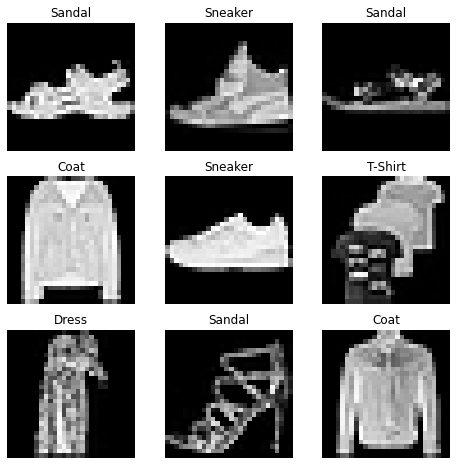

Feature batch shape : torch.Size([64, 1, 28, 28])
Label batch shape : torch.Size([64])


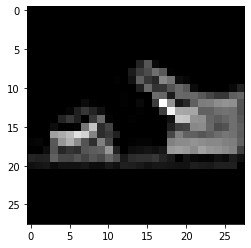

Label : 5
tensor([ 0, 16])
tensor([ 9, 25])
tensor([49, 81])
tensor([36,  4])
tensor([ 1, 64])
tensor([64,  0])
tensor([16,  1])
tensor([49,  9])
tensor([81,  4])
tensor([25, 36])
tensor([49,  4])
tensor([25,  1])
tensor([36, 16])
tensor([81, 64])
tensor([0, 9])
Uscing cuda device


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets
import torchvision.transforms as tr
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
'''
    * 파이토치에서 제공하는 데이터 셋
        - 토치비전(torchvision) : 파이토치에서 제공하는 데이터 셋들이 모여있는 패키지
        - data와 label
        - ex) Fashion-MNIST data
    
    * Dataloader
        - Dataset을 model에 공급할 수 있도록 iterable 객체로 감싸줌
    
'''
# 공개데이터셋에서 학습데이터를 내려받기
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

print(training_data)
print(type(training_data))

print("-"*50)
print(training_data[0])

# 데이터 시각화하기
label_map = {
    0:"T-Shirt",
    1: "Trouser",
    2: "PullOver",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3

for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()


'''
    * DataLoader 만들기
        - 데이터 준비
        - 학습에 사용될 데이터 전체를 보관했다가 모델 학습을 할 때 배치(batch) 크기만큼 데이터를 꺼내서 사용
        - 내부적으로 반복자(iterator)에 포함된 인덱스(index)를 이용해서 배치크기만큼 데이터를 반환함
        
'''
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

# DataLoader 를 통해 반복하기(iterate)
# 이미지와 정답(label)을 표시하기
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Label batch shape : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label : {label}")


'''
    * Custom Dataset, Data Loader 만들기
        - 딥러닝은 기본적으로 대량의 데이터 이용하여 모델을 학습
        - 데이터를 한번에 메모리에 불러와서 훈련시키면 시간과 비용 측면에서 비효율적임
        - 데이터를 한번에 다 부르지 않고 조금씩 나누어 불러서 사용하는 방식
        
        - 1) CustomDataSet 클래스 구현

'''
# 3개 함수 지정 (정해진 틀)
class CustomDataSet(Dataset):
    # 필요한 변수 선언하고, 데이터 셋의 전처리를 해주는 함수
    def __init__(self, np_data, transform=None):
        self.data = np_data
        self.transform = transform
        self.len = np_data.shape[0]

    # 데이터셋의 길이, 즉 샘플의 수를 가져오는 함수
    def __len__(self):
        return self.len

    # 데이터셋에서 특정 데이터를 가져오는 함수(index번째 데이터를 반환하는 함수)
    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
            return sample


'''
    tr.Compose() : 여러개의 이미지 전처리 기능을 연결해서 사용할수 있게 해주는 함수임
                    여기서는 하나의 전처리 기능(square) 함수만 연결되어 있음
'''

def square(sample):
    return sample ** 2

trans = tr.Compose([square])

# 커스텀 데이터 셋 생성
np_data = np.arange(10)

# CustomDataSet 클래스의 인스턴스 생성
# 이미지 전처리 기능인 square 함수를 적용할수 있는 데이터셋
custom_dataset = CustomDataSet(np_data, transform=trans)

# custom_dataset 으로부터 새로운 데이터로더 생성
# batch_size는 각각의 샘플 개수, shuffle은 샘플을 섞어서 읽어옴
custom_dataloader = DataLoader(custom_dataset, batch_size=2, shuffle=True)

for _ in range(3):
    for data in custom_dataloader:
        print(data)
    print("=" * 20)

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Uscing {} device'.format(device))

